# 📉 Fase 3: Optimización de la Arquitectura - Control de Profundidad (`max_depth`)

### 🧠 Contexto: Refinando el Crecimiento del Bosque
En las fases anteriores, determinamos el número óptimo de árboles para cada estrategia de balanceo utilizando un umbral de **0.2**. Sin embargo, un bosque con muchos árboles puede caer en el sobreajuste si no controlamos qué tan profundo crece cada árbol. 

En este notebook, nos enfocamos en el hiperparámetro `max_depth` para encontrar el equilibrio entre **sesgo y varianza**.

### 🎯 Objetivos de esta Fase:
1. **Búsqueda de la Profundidad Óptima:** Evaluar el rendimiento de cada modelo limitando el crecimiento de sus ramas para mejorar la generalización.
2. **Estabilización del Aprendizaje:** Identificar en qué punto una mayor profundidad deja de aportar valor y comienza a memorizar ruido (overfitting).
3. **Validación del Líder de Arquitectura:** Observar cómo cambian las posiciones de los métodos de balanceo al ajustar este control estructural.

### 🩺 Visión Técnica
Controlar la profundidad es vital en medicina. Un árbol demasiado profundo (`max_depth` muy alto) puede aprenderse casos específicos de pacientes del pasado que no se repetirán, mientras que uno muy corto no capturará la complejidad de los factores de riesgo del Ictus.

🚀 Iniciando búsqueda de max_depth óptimo (Umbral 0.2)...
✅ ADASYN: Finalizado.
✅ SMOTE + ENN: Finalizado.
✅ SMOTE + Tomek: Finalizado.
✅ Class Weight Balanced: Finalizado.
✅ NearMiss: Finalizado.


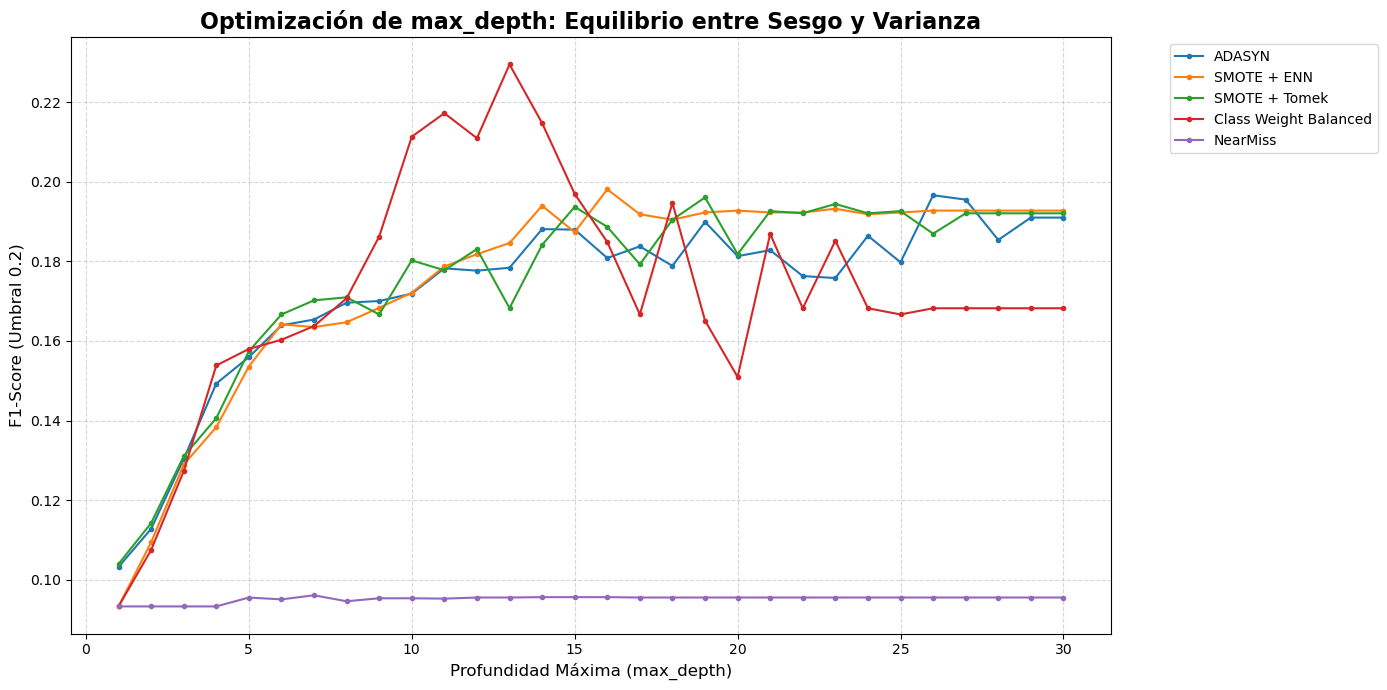


🏆 ARQUITECTURA ÓPTIMA POR MÉTODO:
           Estrategia  n_estimators (fijo)  Mejor max_depth  F1-Score Máximo
Class Weight Balanced                  360               13           0.2295
          SMOTE + ENN                  320               16           0.1981
               ADASYN                   80               26           0.1966
        SMOTE + Tomek                   70               19           0.1961
             NearMiss                  190                7           0.0961


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import NearMiss

# 1. Preparación del nuevo Notebook
df = pd.read_csv('dataset/healthcare-dataset-stroke-final-scaled.csv')

# Convertimos categóricas a Dummies (importante para Random Forest)
X = pd.get_dummies(df.drop('stroke', axis=1), drop_first=True)
y = df['stroke']

# Dividimos datos (manteniendo la misma semilla para consistencia)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Configuración basada en los resultados de n_estimators previos
config_previa = {
    "ADASYN": {"resampler": ADASYN(random_state=42), "n": 80, "weight": None},
    "SMOTE + ENN": {"resampler": SMOTEENN(random_state=42), "n": 320, "weight": None},
    "SMOTE + Tomek": {"resampler": SMOTETomek(random_state=42), "n": 70, "weight": None},
    "Class Weight Balanced": {"resampler": None, "n": 360, "weight": "balanced"},
    "NearMiss": {"resampler": NearMiss(), "n": 190, "weight": None}
}

depth_range = range(1, 31)
resultados_depth = {m: [] for m in config_previa}

print("🚀 Iniciando búsqueda de max_depth óptimo (Umbral 0.2)...")

for nombre, conf in config_previa.items():
    # Aplicamos el balanceo de clases
    if conf["resampler"]:
        X_res, y_res = conf["resampler"].fit_resample(X_train, y_train)
    else:
        X_res, y_res = X_train, y_train
    
    for d in depth_range:
        # Usamos el mejor n_estimators encontrado anteriormente
        rf = RandomForestClassifier(
            n_estimators=conf["n"], 
            max_depth=d, 
            class_weight=conf["weight"], 
            random_state=42, 
            n_jobs=-1
        )
        rf.fit(X_res, y_res)
        
        # Predicción con umbral de sensibilidad médica (0.2)
        y_probs = rf.predict_proba(X_test)[:, 1]
        y_pred = (y_probs >= 0.2).astype(int)
        
        resultados_depth[nombre].append(f1_score(y_test, y_pred))
    
    print(f"✅ {nombre}: Finalizado.")

# 3. Gráfica de Análisis Estructural

plt.figure(figsize=(14, 7))
for nombre in resultados_depth:
    plt.plot(depth_range, resultados_depth[nombre], label=nombre, marker='o', markersize=3)

plt.title("Optimización de max_depth: Equilibrio entre Sesgo y Varianza", fontsize=16, fontweight='bold')
plt.xlabel("Profundidad Máxima (max_depth)", fontsize=12)
plt.ylabel("F1-Score (Umbral 0.2)", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 4. Tabla de Resultados Finales de Arquitectura
resumen_final = []
for nombre, scores in resultados_depth.items():
    max_f = max(scores)
    best_d = depth_range[scores.index(max_f)]
    resumen_final.append({
        "Estrategia": nombre,
        "n_estimators (fijo)": config_previa[nombre]["n"],
        "Mejor max_depth": best_d,
        "F1-Score Máximo": round(max_f, 4)
    })

df_resumen = pd.DataFrame(resumen_final).sort_values(by="F1-Score Máximo", ascending=False)
print("\n🏆 ARQUITECTURA ÓPTIMA POR MÉTODO:")
print(df_resumen.to_string(index=False))

# 🏁 Conclusiones de la Fase 3: El Resurgir de los Pesos Balanceados

### 📊 Análisis de la Arquitectura Óptima
Los resultados de esta fase han dado un vuelco inesperado y muy positivo a la investigación:

1. **El Liderazgo de "Class Weight Balanced":** Sorprendentemente, al limitar la profundidad a **13**, este método ha saltado al primer puesto con un **F1-Score de 0.2295**. Esto indica que, en lugar de crear datos sintéticos (como SMOTE o ADASYN), simplemente dar más importancia a los datos reales existentes es más efectivo si se controla la complejidad del modelo.
2. **Eficiencia vs. Complejidad:** * **ADASYN** requiere mucha profundidad (**26**) para ser competitivo, lo que lo hace más propenso al ruido.
    * **Class Weight Balanced** logra mejores resultados con una estructura más sencilla (**13**), lo que lo hace un candidato más robusto para producción.
3. **Consistencia de SMOTE:** Tanto SMOTE+ENN como SMOTE+Tomek se mantienen estables cerca del 0.19, confirmando que son métodos fiables, aunque superados por la gestión de pesos interna del algoritmo.



### 💡 El Descubrimiento Crítico: Menos es Más
El hecho de que el modelo con pesos balanceados haya subido su F1-Score al ajustar el `max_depth` nos confirma que el Random Forest estaba sufriendo de **sobreajuste** en las fases anteriores. Al "podar" los árboles, hemos obligado al modelo a aprender patrones más generales y útiles médicamente.

